## P48 Training on Wikitext 
- Ok so I'm pretty sure I'll want to try a couple variants here -> actually maybe 3-4 variants
- Batch size 1, medium length text, same batch each step
- Batch size 1, long text, same batch each step
- Batch size N, long text, same batch each step
- Differen batches each step

In [1]:
# ! pip install transformers matplotlib tqdm huggingface_hub

In [1]:
# from huggingface_hub import login
# login()

In [2]:
import torch
from transformers import pipeline
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import copy
from collections import OrderedDict

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from transformers import LlamaForCausalLM, PreTrainedTokenizerFast, LlamaConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

device='cuda'

In [3]:
model_id = "meta-llama/Llama-3.2-1B"

#Pretrained
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.eval();

## Setup Dataset

In [4]:
tokenizer.pad_token = tokenizer.eos_token

In [22]:
from datasets import load_dataset
from torch.utils.data import DataLoader

ds = load_dataset("Salesforce/wikitext", "wikitext-2-v1", split='train')

# Define preprocessing function
def preprocess_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

# Apply preprocessing in batches
tokenized_dataset = ds.map(
    preprocess_function,
    batched=True,
    remove_columns=["text"]
)

# Ensure dataset returns PyTorch tensors
tokenized_dataset.set_format(type="torch")

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

In [24]:
# Create DataLoader
batch_size = 1
dataloader = DataLoader(
    tokenized_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [34]:
# for batch in dataloader:
#     # Move batch to device
#     batch = {k: v.to(device) for k, v in batch.items()}
#     # outputs = model(**batch, labels=batch["input_ids"])
#     break

In [37]:
dataloader_iterator = iter(dataloader)

In [44]:
batch = next(dataloader_iterator)
batch = {k: v.to(device) for k, v in batch.items()}

In [45]:
batch

{'input_ids': tensor([[128000,    366,   3200,     29,    374,   2500,  24549,    430,    706,
             810,   6051,   1027,  25181,    505,   7665,  57749,    315,    279,
           11722,  70479,    292,    662,   1102,    374,    264,   2027,    315,
             279,  31085,    315,  19185,    354,  56989,  13935,    555,  24955,
             571,     12,     31,  80836,  25407,    662,    366,   3200,     29,
             374,    315,   9099,    366,   3200,     29,   5820,   7863,    449,
             279,   1023,  13307,    662,    362,   1543,   6388,   3167,   7063,
             689,    323,   5552,   9606,    527,   3967,    439,   7524,    366,
            3200,     29,    315,    366,   3200,     29,   2652,   1063,   9606,
           37455,    366,   3200,     29,    311,   5990,    315,    709,    311,
             220,   3443,   3115,   1884,  11383,   1766,    304,  11012,    662,
             366,   3200,     29,    374,   3118,    304,  14098,    571,     12,
   

In [46]:
tokenizer.decode(batch['input_ids'][0])

'<|begin_of_text|> <unk> is another compound that has more recently been isolated from European specimens of the fly agaric. It is a product of the breakdown of ibotenic acid by ultra @-@ violet radiation. <unk> is of minor <unk> activity compared with the other agents. Amanita muscaria and related species are known as effective <unk> of <unk> ; some species concentrate <unk> to levels of up to 400 times those typically found in plants. <unk> is present in fruit @-@ bodies as an <unk> compound called <unk>. The biological importance of the <unk'

In [ ]:
dataloader

In [49]:
# batch

## Configuration for this run

In [50]:
output_dir='/workspace/apr_27_1'
num_points=32 
n_steps=128 
lr=1e-7
delayed_viz_start=0 #e.g. set to 10 if i only want to start renderding after the 10th optimiation steps

## Support Functions

In [51]:
def get_random_directions(params, seed=None):
    """
    Generate random direction vectors for each parameter tensor.
    
    Args:
        params: List of (name, parameter) tuples from model.named_parameters()
        seed: Random seed for reproducibility
        
    Returns:
        direction: OrderedDict mapping parameter names to random direction tensors
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    direction = OrderedDict()
    for name, param in params:
        if param.requires_grad:
            direction[name] = torch.randn_like(param.data)
    
    return direction

def normalize_direction(direction, params):
    """
    Normalize the direction tensors to match the norm of each parameter tensor.
    
    Args:
        direction: OrderedDict mapping parameter names to direction tensors
        params: List of (name, parameter) tuples from model.named_parameters()
        
    Returns:
        normalized_direction: OrderedDict with normalized direction tensors
    """
    param_dict = OrderedDict(params)
    normalized_direction = OrderedDict()
    
    for name, dir_tensor in direction.items():
        param_norm = torch.norm(param_dict[name].data)
        dir_norm = torch.norm(dir_tensor)
        
        # Avoid division by zero
        if dir_norm > 0:
            normalized_direction[name] = dir_tensor * (param_norm / dir_norm)
        else:
            normalized_direction[name] = dir_tensor
    
    return normalized_direction

### Setup example and run some Computation Checks

In [52]:
text = "The capital of France is Paris"
inputs = tokenizer(text, return_tensors="pt").to(device)
input_ids = inputs["input_ids"]

In [53]:
with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)

my_probs=F.softmax(outputs.logits, dim=-1)
y_one_hot=F.one_hot(input_ids, num_classes=model.config.vocab_size)
correct_next_token_probs = (my_probs[:,:-1]*y_one_hot[:,1:]).sum(-1) #I'm sure there's waaay more efficient ways to do this
my_loss=-torch.log(correct_next_token_probs).mean()
print(my_loss.item(), outputs.loss.item())

3.3751838207244873 3.3751838207244873


In [54]:
with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)

my_probs=F.softmax(outputs.logits, dim=-1)
y_one_hot=F.one_hot(input_ids, num_classes=model.config.vocab_size)
correct_next_token_probs = (my_probs[:,:-1]*y_one_hot[:,1:]).sum(-1) #I'm sure there's waaay more efficient ways to do this
my_loss=-torch.log(correct_next_token_probs).mean()

paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
print(my_loss.item(), outputs.loss.item(), paris_only_loss)

3.3751838207244873 3.3751838207244873 0.9376916737061879


In [55]:
sI=np.argsort(my_probs[0,5, :].detach().cpu().float().numpy())[::-1]
for i in sI[:10]:
    print(i, round(my_probs[0, 5, i].item(),5), tokenizer.decode([i]))

12366 0.39153  Paris
264 0.08419  a
279 0.0704  the
832 0.03096  one
1101 0.03061  also
2162 0.02528  home
3967 0.02462  known
539 0.01659  not
459 0.01241  an
7559 0.01172  located


In [60]:
prefix='pretrained_'
filtered_params = [(name, p) for name, p in model.named_parameters() if p.requires_grad]
# layers_name='all'

layers_name='first_8'
filtered_params = filtered_params[1:73] 

# layers_name='last_8'
# filtered_params = filtered_params[73:] #Last 8 layers - some nice structue, but yeah more parabolic than I would like

random_seed_1=11
random_seed_2=111

# Generate and normalize random directions
direction1 = get_random_directions(filtered_params, seed=random_seed_1)
direction2 = get_random_directions(filtered_params, seed=random_seed_2)

direction1 = normalize_direction(direction1, filtered_params)
direction2 = normalize_direction(direction2, filtered_params)

original_params = OrderedDict()
for name, param in filtered_params:
    original_params[name] = param.data.clone()

alphas=np.linspace(-2.5, 2.5, num_points)
betas=np.linspace(-2.5, 2.5, num_points)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [57]:
os.makedirs(output_dir, exist_ok=True)

PermissionError: [Errno 13] Permission denied: '/workspace'

In [61]:
#Move away from center
alpha_shift=-0.9 
beta_shift=0.05

alphas_shifted=alphas-alpha_shift #Shift scan points to keep thing consistent. 
betas_shifted=betas-beta_shift

#Replace actual model parameters with the shifted ones. 
for name, param in model.named_parameters():
    if name in direction1 and name in direction2:
        param.data = original_params[name] + alpha_shift * direction1[name] + beta_shift * direction2[name]

#Make copy for scaning/replacing. 
original_params_shifted = OrderedDict()
for name, param in filtered_params:
    original_params_shifted[name] = param.data.clone()

100%|█████████████████████████████████████████| 32/32 [00:33<00:00,  1.04s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 103.00 MiB is free. Including non-PyTorch memory, this process has 23.13 GiB memory in use. Of the allocated memory 22.79 GiB is allocated by PyTorch, and 32.90 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

<Figure size 640x480 with 0 Axes>

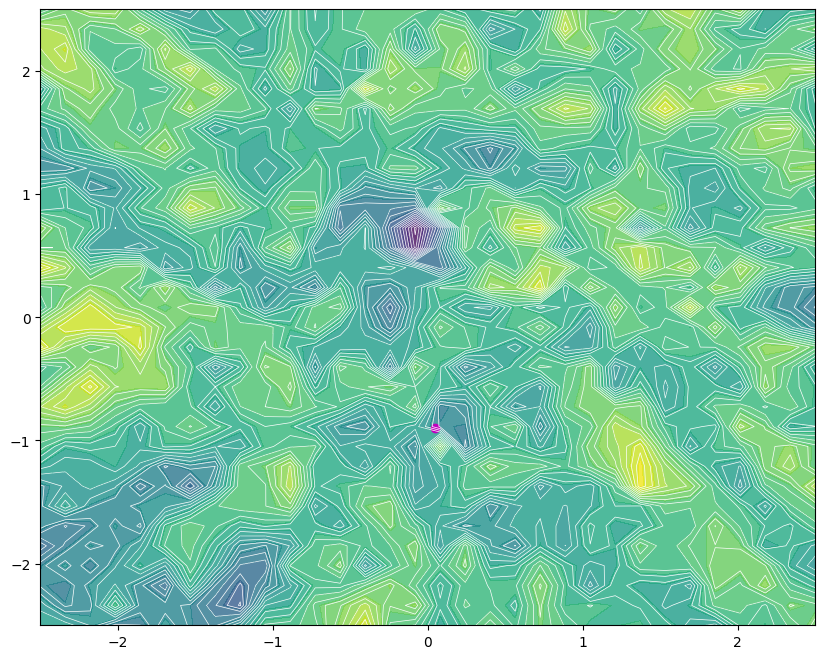

In [62]:
model_outputs=[]
for step in range(n_steps):
    losses=[]
    model.eval();

    with torch.no_grad():
        for i, alpha in enumerate(tqdm(alphas_shifted)):
            losses.append([])
            for j, beta in enumerate(betas_shifted):
                for name, param in model.named_parameters():
                    if name in direction1:
                        param.data = original_params_shifted[name] + alpha * direction1[name] + beta*direction2[name]
                
                outputs = model(input_ids, labels=input_ids)
                my_probs=F.softmax(outputs.logits, dim=-1)
                paris_only_loss=-np.log(my_probs[0, 5, 12366].item()) #Just Paris
                losses[-1].append(paris_only_loss)
        
        for name, param in model.named_parameters(): # Restore original shifted parameters
            if name in original_params: 
                param.data.copy_(original_params_shifted[name])
    losses=np.array(losses)
    # np.save(output_dir +'/'+str(step).zfill(3), losses) #Save loss landscape
    
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))
    contourf = ax.contourf(alphas, betas, losses, 20, cmap='viridis', alpha=0.8)
    contour = ax.contour(alphas, betas, losses, 30, colors='white', linewidths=0.5)
    plt.scatter(beta_shift, alpha_shift, c='m')
    # plt.savefig(output_dir +'/'+str(step).zfill(3)+'.png')

    model.train()
    optimizer.zero_grad()
    outputs = model(**batch, labels=batch['input_ids'])
    loss = outputs.loss #Ok not just paris loss here -> not sure how much I'm worried about that
    loss.backward()
    optimizer.step()

    #After training I need to replace original_params_shifted with the new trained values
    original_params_shifted = OrderedDict()
    for name, param in filtered_params:
        original_params_shifted[name] = param.data.clone()

In [ ]:
# model_outputs=[]
# for step in range(n_steps):
#     losses=[]
#     model.eval();

#     with torch.no_grad(): #Check current outputs
#         outputs = model(input_ids, labels=input_ids)
#         my_probs=F.softmax(outputs.logits, dim=-1)
#         sI=np.argsort(my_probs[0,5, :].detach().cpu().float().numpy())[::-1]
#         current_outs=[[12366,  round(my_probs[0, 5, 12366].item(), 7), ' Paris']] #Put paris at top
#         for i in sI[:10]:
#             current_outs.append([i, round(my_probs[0, 5, i].item(),7), tokenizer.decode([i])])
#         model_outputs.append(current_outs)
#         print(step, 'loss=', -np.log(my_probs[0, 5, 12366].item()), current_outs[0], current_outs[1])

#     if step>=delayed_viz_start: #Do I want to compute loss landscape at this step?
#         with torch.no_grad():
#             for i, alpha in enumerate(tqdm(alphas_shifted)):
#                 losses.append([])
#                 for j, beta in enumerate(betas_shifted):
#                     for name, param in model.named_parameters():
#                         if name in direction1:
#                             param.data = original_params_shifted[name] + alpha * direction1[name] + beta*direction2[name]
                    
#                     outputs = model(input_ids, labels=input_ids)
#                     my_probs=F.softmax(outputs.logits, dim=-1)
#                     paris_only_loss=-np.log(my_probs[0, 5, 12366].item()) #Just Paris
#                     losses[-1].append(paris_only_loss)
            
#             for name, param in model.named_parameters(): # Restore original shifted parameters
#                 if name in original_params: 
#                     param.data.copy_(original_params_shifted[name])
#         losses=np.array(losses)
#         # np.save(output_dir +'/'+str(step).zfill(3), losses) #Save loss landscape
        
#         plt.clf()
#         fig, ax = plt.subplots(figsize=(10, 8))
#         contourf = ax.contourf(alphas, betas, losses, 20, cmap='viridis', alpha=0.8)
#         contour = ax.contour(alphas, betas, losses, 30, colors='white', linewidths=0.5)
#         plt.scatter(beta_shift, alpha_shift, c='m')
#         # plt.savefig(output_dir +'/'+str(step).zfill(3)+'.png')

#     model.train()
#     optimizer.zero_grad()
#     outputs = model(**inputs, labels=inputs['input_ids'])
#     loss = outputs.loss #Ok not just paris loss here -> not sure how much I'm worried about that
#     loss.backward()
#     optimizer.step()

#     #After training I need to replace original_params_shifted with the new trained values
#     original_params_shifted = OrderedDict()
#     for name, param in filtered_params:
#         original_params_shifted[name] = param.data.clone()

In [ ]:
# tokenizer.decode(12366)


In [ ]:
current_outs